# Exploring UniRep representations of MS2 data

In [1]:
!pip install git+https://github.com/ElArkk/jax-unirep.git --upgrade
!pip install optuna
!pip install biopython

  Cloning https://github.com/ElArkk/jax-unirep.git to /tmp/pip-req-build-g9rmdtcx
  Running command git clone -q https://github.com/ElArkk/jax-unirep.git /tmp/pip-req-build-g9rmdtcx
  Created wheel for jax-unirep: filename=jax_unirep-0.1-cp36-none-any.whl size=67744668 sha256=56c60499c9f977beafd903e0d567e3be916fd5fc7f3d6d76b1bffb491bc2f40a
  Stored in directory: /tmp/pip-ephem-wheel-cache-9_vq4h84/wheels/08/4d/ac/6e75862c118d1ad82122f410859524b20190ce7a821b76ffcd
Successfully built jax-unirep
     |████████████████████████████████| 163kB 4.8MB/s 
     |████████████████████████████████| 1.1MB 16.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 112kB 27.9MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 61kB 7.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
gdrive_path = "/content/drive/My Drive/Colab Notebooks/UniRep/"
!ls "/content/drive/My Drive/Colab Notebooks/UniRep"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
2MS2_data_exploration.ipynb	       MS2_single_AA_mut_fitness.npy
2MS2_weights			       MS2_single_AA_mut_seqs.txt
BLAC_data_exploration.ipynb	       out_domain_val_set.fasta.txt
blac_fitness.txt		       out_domain_val_set_formatted.fasta.txt
blac_seqs.txt			       PETase_data_exploration.ipynb
blac_unirep_global_init_1	       PETase_mutant_fitness.txt
blac_unirep_global_init_1.zip	       PETase_mutant_seqs.txt
blac_unirep_random_init_1.zip	       PETase_weigh

In [3]:
from jax_unirep import get_reps, fit
from jax_unirep.utils import load_params_1900
from Bio import SeqIO
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### Load sequences

In [0]:
# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    fasta_seqs = SeqIO.parse(open(gdrive_path + name + '.fasta.txt'),'fasta')
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    
    return data

In [0]:
# read sequence text file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_labeled_data(name):
    seqs = np.loadtxt(gdrive_path + name + '_seqs.txt', dtype='str')
    fitnesses = np.load(gdrive_path + name + '_fitness.npy')
    data = []
    for seq, fitness in zip(seqs, fitnesses):
        data.append([str(seq).strip(), fitness])
    
    return data

In [8]:
# load labeled PETase top model training data
single_mut_df = pd.DataFrame(read_labeled_data('MS2_single_AA_mut'), columns = ['sequence', 'fitness'])
double_mut_df = pd.DataFrame(read_labeled_data('MS2_double_AA_mut'), columns = ['sequence', 'fitness'])

double_mut_df.head()

,sequence,fitness
0,ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,0.0732
1,ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,0.1380
2,ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,0.0255
3,ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,0.2100
4,ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,0.0211


## Get Reps


In [0]:
# load params for MS2 evotuned weights

MS2_params1 = load_params_1900(gdrive_path + '2MS2_weights/2MS2_1E5_iter_3')
MS2_params2 = load_params_1900(gdrive_path + '2MS2_weights/2MS2_5E6_iter_11')


In [10]:
# GET reps for LABELED DATA:

N_seqs = len(single_mut_df)
print("N_seqs:", N_seqs)

# vary batches based on memory available
# this google colab can handle around 1000 seqs per batch for sure
N_BATCHES = 1

BATCH_LEN = int(np.ceil(N_seqs/N_BATCHES))

# for unirep

# get 1st sequence representation
unirep, _, _ = get_reps(single_mut_df.sequence[0])

feat_cols = [ 'feat' + str(j) for j in range(1, unirep.shape[1] + 1) ]
unirep_df = pd.DataFrame(unirep, columns=feat_cols)
unirep_df.insert(0, "sequence", single_mut_df.sequence[0])
unirep_df.insert(1, "fitness", single_mut_df.fitness[0])

# get the rest of the sequences and append to df
for i in range(N_BATCHES):
  this_unirep, _, _ = get_reps(single_mut_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ] )
  this_unirep_df = pd.DataFrame(this_unirep, columns=feat_cols)
  this_unirep_df.insert(0, "sequence", single_mut_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  this_unirep_df.insert(1, "fitness", single_mut_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  unirep_df = pd.concat([unirep_df.reset_index(drop=True), this_unirep_df.reset_index(drop=True)]).reset_index(drop=True)

unirep_df.head()

# do the same for eunirep

# get 1st sequence representation
eunirep, _, _ = get_reps(single_mut_df.sequence[0], params=MS2_params1)

efeat_cols = [ 'feat' + str(j) for j in range(1, eunirep.shape[1] + 1) ]
eunirep_df = pd.DataFrame(eunirep, columns=efeat_cols)
eunirep_df.insert(0, "sequence", single_mut_df.sequence[0])
eunirep_df.insert(1, "fitness", single_mut_df.fitness[0])

# get the rest of the sequences and append to df
for i in range(N_BATCHES):
  this_eunirep, _, _ = get_reps(single_mut_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ], params=MS2_params1)
  this_eunirep_df = pd.DataFrame(this_eunirep, columns=efeat_cols)
  this_eunirep_df.insert(0, "sequence", single_mut_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  this_eunirep_df.insert(1, "fitness", single_mut_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  eunirep_df = pd.concat([eunirep_df.reset_index(drop=True), this_eunirep_df.reset_index(drop=True)]).reset_index(drop=True)

eunirep_df.head()

# do the same for eunirep2

# get 1st sequence representation
eunirep2, _, _ = get_reps(single_mut_df.sequence[0], params=MS2_params2)

efeat_cols = [ 'feat' + str(j) for j in range(1, eunirep2.shape[1] + 1) ]
eunirep2_df = pd.DataFrame(eunirep2, columns=efeat_cols)
eunirep2_df.insert(0, "sequence", single_mut_df.sequence[0])
eunirep2_df.insert(1, "fitness", single_mut_df.fitness[0])

# get the rest of the sequences and append to df
for i in range(N_BATCHES):
  this_eunirep, _, _ = get_reps(single_mut_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ], params=MS2_params2)
  this_eunirep_df = pd.DataFrame(this_eunirep, columns=efeat_cols)
  this_eunirep_df.insert(0, "sequence", single_mut_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  this_eunirep_df.insert(1, "fitness", single_mut_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  eunirep2_df = pd.concat([eunirep2_df.reset_index(drop=True), this_eunirep_df.reset_index(drop=True)]).reset_index(drop=True)

eunirep2_df.head()



N_seqs: 1861


,sequence,fitness,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,feat32,feat33,feat34,feat35,feat36,feat37,feat38,...,feat1861,feat1862,feat1863,feat1864,feat1865,feat1866,feat1867,feat1868,feat1869,feat1870,feat1871,feat1872,feat1873,feat1874,feat1875,feat1876,feat1877,feat1878,feat1879,feat1880,feat1881,feat1882,feat1883,feat1884,feat1885,feat1886,feat1887,feat1888,feat1889,feat1890,feat1891,feat1892,feat1893,feat1894,feat1895,feat1896,feat1897,feat1898,feat1899,feat1900
0,ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,-0.183447,0.012654,0.373320,0.276871,-0.006105,-0.318430,0.135733,0.071688,-0.001426,-0.013041,0.029906,0.032300,-0.002254,0.126245,0.089372,0.009643,0.011237,0.053134,0.002645,0.156106,-0.036152,-0.061088,-0.249388,0.026891,0.031375,-0.261560,0.028445,0.034681,0.031214,-0.021963,-0.012215,-0.404038,-0.023604,0.079668,-0.080257,-0.073689,-0.032209,0.026587,0.165221,...,-0.108772,0.097840,0.167700,0.203938,-0.078186,-0.198964,0.005209,-0.120297,-0.008919,0.009998,0.159283,0.013303,-0.027113,-0.052200,-0.129685,-0.116877,0.191926,-0.132957,0.050177,0.235134,-0.091298,-0.107520,0.093026,-0.042823,0.030658,0.020952,0.101051,-0.080119,-0.002234,-0.007107,-0.062829,0.033110,-0.051080,0.041195,-0.221842,0.076480,0.006656,-0.162591,-0.249360,-0.046053
1,SSNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,-0.251050,0.019343,0.269828,0.231644,-0.003775,-0.389737,0.190357,-0.028209,-0.040371,-0.012905,0.025981,0.030077,-0.022950,0.171393,0.141672,0.008760,0.013235,0.046571,0.027195,0.145916,-0.054161,-0.061762,-0.207808,0.029281,0.005038,-0.254602,-0.039060,0.045236,0.027701,-0.026588,0.001012,-0.398827,-0.025701,0.061520,0.017799,-0.047257,0.194065,0.006259,0.167753,...,-0.115939,0.067540,0.185754,0.457796,-0.061121,-0.207114,0.009287,-0.187182,-0.011250,0.124821,0.219966,0.007916,0.099917,-0.072976,-0.186285,-0.119774,0.080095,-0.179157,0.035615,0.189213,-0.025661,-0.064821,0.053954,-0.027271,0.024920,0.017601,0.069827,0.005594,-0.006633,-0.007648,-0.028963,0.069237,-0.074865,0.059732,-0.272499,0.034030,0.013368,-0.159625,-0.181914,-0.028704
2,TSNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,0.844885,0.020361,0.306540,0.286026,-0.006653,-0.397871,0.185139,0.002868,-0.011731,-0.011268,0.046218,0.032572,-0.023817,0.167874,0.155098,0.008576,0.012410,0.054283,0.007453,0.199641,-0.050244,-0.061942,-0.227545,0.032783,0.007289,-0.263351,-0.021146,0.038787,0.028808,-0.027622,-0.013241,-0.394586,-0.031830,0.074002,-0.024561,-0.067794,0.062777,0.030558,0.211930,...,-0.109858,0.075386,0.169363,0.350517,-0.070992,-0.206790,0.009660,-0.183923,-0.009944,0.049887,0.203271,0.005508,0.053011,-0.073883,-0.140306,-0.136271,0.100856,-0.125524,0.010848,0.215638,-0.053158,-0.086827,0.062273,-0.031216,0.019775,0.039445,0.091955,0.024905,-0.018389,0.008031,-0.070883,0.041548,-0.073789,0.056794,-0.267415,0.064761,0.010933,-0.199256,-0.241415,-0.036357
3,VSNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,-0.146906,0.013014,0.289787,0.238238,-0.005495,-0.340507,0.186008,-0.015120,-0.008861,-0.011163,0.051692,0.033509,-0.018433,0.199094,0.159174,0.008377,0.011152,0.050724,0.000802,0.205842,-0.044418,-0.056554,-0.250936,0.034558,0.014606,-0.284881,-0.027710,0.025767,0.030941,-0.028932,-0.011758,-0.391117,-0.038262,0.081948,-0.020719,-0.066783,0.049141,0.034237,0.201477,...,-0.088015,0.071677,0.162885,0.256801,-0.069379,-0.206542,0.008858,-0.192409,-0.002864,0.052956,0.218254,0.014004,0.041020,-0.058619,-0.140164,-0.120139,0.115455,-0.118098,-0.011606,0.278944,-0.060393,-0.094602,0.140191,-0.031876,0.026657,0.031777,0.112518,0.000355,-0.007798,-0.017825,-0.070225,0.041589,-0.063874,0.046476,-0.234788,0.059597,0.007839,-0.282969,-0.241105,-0.023698
4,ESNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,-0.811896,0.016574,0.160957,0.167549,-0.004510,-0.471099,0.131503,-0.060532,-0.076298,-0.013

In [11]:
# DO THE SAME THING FOR THE DOUBLE MUTANTS:

N_seqs = len(double_mut_df)
print("N_seqs:", N_seqs)

# vary batches based on memory available
# this google colab can handle around 1000 seqs per batch for sure
N_BATCHES = 1

BATCH_LEN = int(np.ceil(N_seqs/N_BATCHES))

# for unirep

# get 1st sequence representation
unirep, _, _ = get_reps(double_mut_df.sequence[0])

feat_cols = [ 'feat' + str(j) for j in range(1, unirep.shape[1] + 1) ]
unirep_double_df = pd.DataFrame(unirep, columns=feat_cols)
unirep_double_df.insert(0, "sequence", double_mut_df.sequence[0])
unirep_double_df.insert(1, "fitness", double_mut_df.fitness[0])

# get the rest of the sequences and append to df
for i in range(N_BATCHES):
  this_unirep, _, _ = get_reps(double_mut_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ] )
  this_unirep_df = pd.DataFrame(this_unirep, columns=feat_cols)
  this_unirep_df.insert(0, "sequence", double_mut_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  this_unirep_df.insert(1, "fitness", double_mut_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  unirep_double_df = pd.concat([unirep_double_df.reset_index(drop=True), this_unirep_df.reset_index(drop=True)]).reset_index(drop=True)

unirep_double_df.head()

# do the same for eunirep

# get 1st sequence representation
eunirep, _, _ = get_reps(double_mut_df.sequence[0], params=MS2_params1)

efeat_cols = [ 'feat' + str(j) for j in range(1, eunirep.shape[1] + 1) ]
eunirep_double_df = pd.DataFrame(eunirep, columns=efeat_cols)
eunirep_double_df.insert(0, "sequence", double_mut_df.sequence[0])
eunirep_double_df.insert(1, "fitness", double_mut_df.fitness[0])

# get the rest of the sequences and append to df
for i in range(N_BATCHES):
  this_eunirep, _, _ = get_reps(double_mut_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ], params=MS2_params1)
  this_eunirep_df = pd.DataFrame(this_eunirep, columns=efeat_cols)
  this_eunirep_df.insert(0, "sequence", double_mut_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  this_eunirep_df.insert(1, "fitness", double_mut_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  eunirep_double_df = pd.concat([eunirep_double_df.reset_index(drop=True), this_eunirep_df.reset_index(drop=True)]).reset_index(drop=True)

eunirep_double_df.head()

# do the same for eunirep2

# get 1st sequence representation
eunirep2, _, _ = get_reps(double_mut_df.sequence[0], params=MS2_params2)

efeat_cols = [ 'feat' + str(j) for j in range(1, eunirep2.shape[1] + 1) ]
eunirep2_double_df = pd.DataFrame(eunirep2, columns=efeat_cols)
eunirep2_double_df.insert(0, "sequence", double_mut_df.sequence[0])
eunirep2_double_df.insert(1, "fitness", double_mut_df.fitness[0])

# get the rest of the sequences and append to df
for i in range(N_BATCHES):
  this_eunirep, _, _ = get_reps(double_mut_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ], params=MS2_params2)
  this_eunirep_df = pd.DataFrame(this_eunirep, columns=efeat_cols)
  this_eunirep_df.insert(0, "sequence", double_mut_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  this_eunirep_df.insert(1, "fitness", double_mut_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  eunirep2_double_df = pd.concat([eunirep2_double_df.reset_index(drop=True), this_eunirep_df.reset_index(drop=True)]).reset_index(drop=True)

eunirep2_double_df.head()

N_seqs: 5466


,sequence,fitness,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,feat32,feat33,feat34,feat35,feat36,feat37,feat38,...,feat1861,feat1862,feat1863,feat1864,feat1865,feat1866,feat1867,feat1868,feat1869,feat1870,feat1871,feat1872,feat1873,feat1874,feat1875,feat1876,feat1877,feat1878,feat1879,feat1880,feat1881,feat1882,feat1883,feat1884,feat1885,feat1886,feat1887,feat1888,feat1889,feat1890,feat1891,feat1892,feat1893,feat1894,feat1895,feat1896,feat1897,feat1898,feat1899,feat1900
0,ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,0.0732,0.012787,0.355652,0.270006,-0.006018,-0.316024,0.140117,0.080466,-0.002172,-0.013082,0.027408,0.032153,-0.002180,0.122228,0.090507,0.009685,0.011176,0.053067,0.005944,0.158759,-0.036300,-0.059060,-0.245938,0.026332,0.031811,-0.256913,0.028318,0.040660,0.031009,-0.023350,-0.013698,-0.400708,-0.024535,0.079554,-0.077693,-0.069325,-0.035004,0.025020,0.164336,...,-0.108104,0.095521,0.160718,0.204463,-0.079111,-0.198387,0.005210,-0.130892,-0.008860,0.020086,0.157798,0.012468,-0.024055,-0.054005,-0.129682,-0.117959,0.192816,-0.131286,0.044846,0.237377,-0.092737,-0.104989,0.089129,-0.042141,0.030206,0.016272,0.092432,-0.088703,-0.000179,-0.011862,-0.052467,0.035936,-0.047511,0.035349,-0.225956,0.076939,0.006820,-0.132586,-0.251025,-0.049806
1,ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,0.1380,0.015825,0.336259,0.246304,-0.007527,-0.353470,0.182245,-0.002188,-0.003642,-0.012035,0.043115,0.029285,-0.020720,0.195092,0.147946,0.008159,0.010912,0.047591,0.015815,0.201405,-0.046386,-0.055598,-0.240642,0.032502,0.014186,-0.281804,-0.017720,0.033074,0.028589,-0.023871,-0.007176,-0.383044,-0.035945,0.072746,-0.025895,-0.067271,0.043707,0.030370,0.188056,...,-0.102434,0.073037,0.180806,0.308107,-0.072694,-0.205912,0.005223,-0.189591,-0.006585,0.071111,0.197113,0.007809,0.032555,-0.066510,-0.140339,-0.130562,0.127920,-0.113522,0.009713,0.279003,-0.064688,-0.090958,0.072421,-0.031322,0.032170,0.019346,0.115914,-0.011506,-0.004057,-0.000756,-0.058798,0.033941,-0.074163,0.050064,-0.251502,0.064529,0.011587,-0.186898,-0.230555,-0.039039
2,ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,0.0255,0.015873,0.334353,0.247772,-0.007411,-0.356064,0.183190,-0.001066,-0.002563,-0.011974,0.043877,0.029430,-0.020133,0.194247,0.146908,0.008150,0.010908,0.047741,0.015769,0.203290,-0.046150,-0.055544,-0.240709,0.033247,0.013860,-0.282448,-0.020222,0.032161,0.028535,-0.023442,-0.007266,-0.384378,-0.035571,0.072730,-0.026577,-0.066924,0.036309,0.030997,0.189581,...,-0.101771,0.072461,0.179980,0.306447,-0.072715,-0.206152,0.005223,-0.189294,-0.007128,0.069064,0.199621,0.007789,0.030770,-0.066803,-0.138366,-0.131519,0.128472,-0.112496,0.012335,0.280261,-0.066686,-0.092036,0.071645,-0.031172,0.032479,0.019712,0.117377,-0.011517,-0.004174,0.001060,-0.061270,0.033225,-0.074682,0.051777,-0.249478,0.064560,0.011637,-0.190457,-0.229292,-0.038945
3,ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,0.2100,0.016027,0.330342,0.244135,-0.006554,-0.357467,0.181036,-0.005661,-0.002326,-0.012001,0.040533,0.029129,-0.018096,0.192635,0.146883,0.008186,0.010887,0.048293,0.012500,0.203211,-0.045938,-0.055037,-0.233291,0.033091,0.013251,-0.281404,-0.022119,0.031644,0.028159,-0.023328,-0.008185,-0.385263,-0.035448,0.072127,-0.020212,-0.068192,0.026464,0.028053,0.191151,...,-0.101301,0.071610,0.180448,0.298179,-0.072365,-0.206268,0.005225,-0.189275,-0.007053,0.063940,0.206497,0.007964,0.032645,-0.068111,-0.137749,-0.131426,0.128879,-0.109299,0.017910,0.279662,-0.064967,-0.092709,0.065981,-0.030223,0.032811,0.024199,0.113601,-0.017288,-0.003924,-0.002937,-0.077150,0.037159,-0.072156,0.053443,-0.244104,0.069046,0.011504,-0.186546,-0.223180,-0.040177
4,ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,0.0211,0.016165,0.326760,0.247866,-0.006624,-0.352809,0.182800,0.004489,-0.001726,-0.012231,0.0407

## Data Exploration

In [12]:
# 3 component PCA on unirep representations:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(unirep_df[feat_cols].values)
unirep_df['pca1'] = pca_result[:,0]
unirep_df['pca2'] = pca_result[:,1] 
unirep_df['pca3'] = pca_result[:,2]
print('UniRep: Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# same thing on eunirep:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(eunirep_df[efeat_cols].values)
eunirep_df['pca1'] = pca_result[:,0]
eunirep_df['pca2'] = pca_result[:,1] 
eunirep_df['pca3'] = pca_result[:,2]
print('eUniRep: Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# same thing on eunirep2:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(eunirep2_df[efeat_cols].values)
eunirep2_df['pca1'] = pca_result[:,0]
eunirep2_df['pca2'] = pca_result[:,1] 
eunirep2_df['pca3'] = pca_result[:,2]
print('eUniRep2: Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# 3 component PCA on unirep representations:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(unirep_double_df[feat_cols].values)
unirep_double_df['pca1'] = pca_result[:,0]
unirep_double_df['pca2'] = pca_result[:,1] 
unirep_double_df['pca3'] = pca_result[:,2]
print('UniRep_double: Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# same thing on eunirep:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(eunirep_double_df[efeat_cols].values)
eunirep_double_df['pca1'] = pca_result[:,0]
eunirep_double_df['pca2'] = pca_result[:,1] 
eunirep_double_df['pca3'] = pca_result[:,2]
print('eUniRep_double: Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# same thing on eunirep2:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(eunirep2_double_df[efeat_cols].values)
eunirep2_double_df['pca1'] = pca_result[:,0]
eunirep2_double_df['pca2'] = pca_result[:,1] 
eunirep2_double_df['pca3'] = pca_result[:,2]
print('eUniRep2_double: Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


UniRep: Explained variation per principal component: [0.5537204  0.12361491 0.05694167]
eUniRep: Explained variation per principal component: [0.3383865  0.19233121 0.07593745]
eUniRep2: Explained variation per principal component: [0.41856644 0.21832809 0.06890316]
UniRep_double: Explained variation per principal component: [0.19009364 0.15089674 0.10588767]
eUniRep_double: Explained variation per principal component: [0.4923582  0.11288086 0.05251276]
eUniRep2_double: Explained variation per principal component: [0.43199554 0.12844326 0.06333097]


<Figure size 432x288 with 0 Axes>

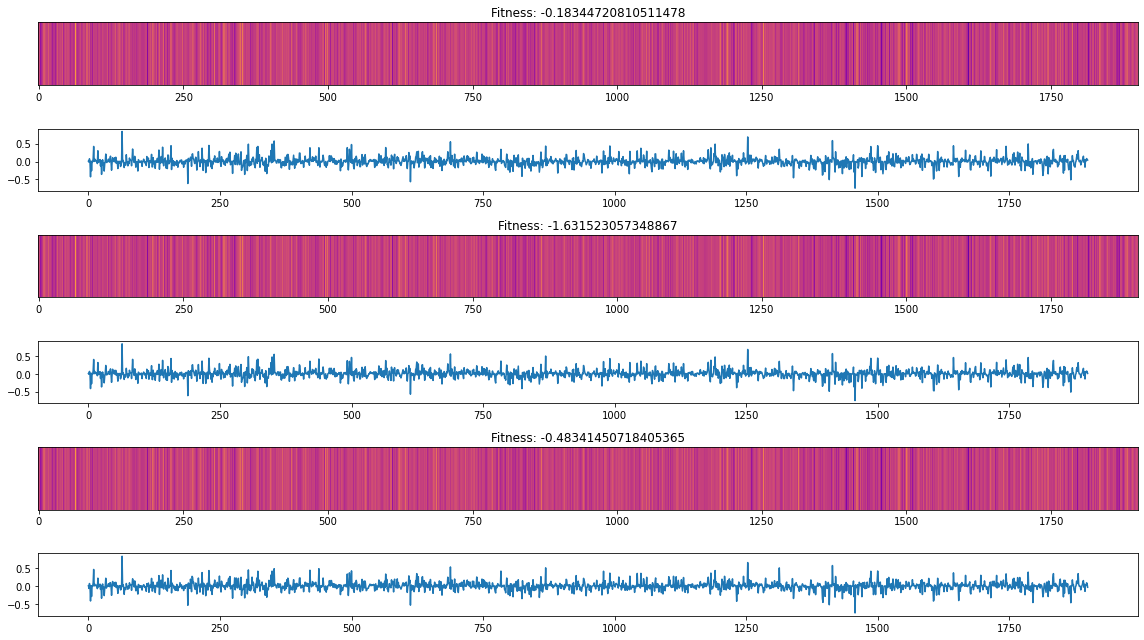

In [13]:
# visualize full representation of each sequence by feature value
# we don't expect to get anything out of these plots
INDCES_TO_SHOW = [0,22,79]

plt.clf()
fig = plt.figure(figsize=(16,3*len(INDCES_TO_SHOW)))
x = np.arange(len(feat_cols))
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]

for i in range(len(INDCES_TO_SHOW)):
  y = unirep_df.loc[INDCES_TO_SHOW[i], feat_cols].values.astype(float)

  ax = fig.add_subplot(len(INDCES_TO_SHOW)*2,1,(i*2+1), title="Fitness: " + str(unirep_df.loc[INDCES_TO_SHOW[i],'fitness']))
  ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
  ax.set_yticks([])
  ax.set_xlim(extent[0], extent[1])

  ax2 = fig.add_subplot(len(INDCES_TO_SHOW)*2,1,i*2+2)
  ax2.plot(x,y)

plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

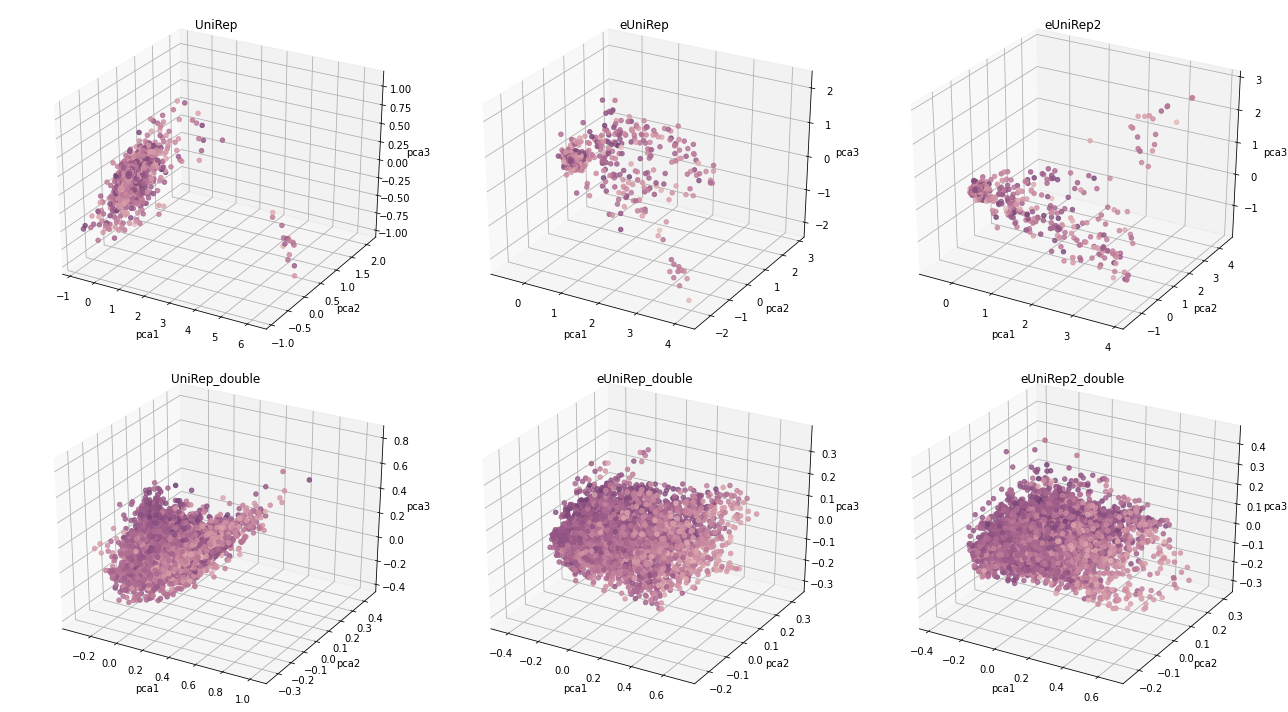

In [14]:
# 3D Plot of first 3 PC's

plt.clf()
fig = plt.figure( figsize=(18,10) )

ax = fig.add_subplot(2,3,1, title="UniRep", projection="3d")
ax.scatter(
    xs=unirep_df["pca1"], 
    ys=unirep_df["pca2"], 
    zs=unirep_df["pca3"], 
    c=unirep_df["fitness"], 
    cmap=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    alpha=0.8
)
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')

ax2 = fig.add_subplot(2,3,2, title="eUniRep", projection="3d")
ax2.scatter(
    xs=eunirep_df["pca1"], 
    ys=eunirep_df["pca2"], 
    zs=eunirep_df["pca3"], 
    c=eunirep_df["fitness"], 
    cmap=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    alpha=0.8
)
ax2.set_xlabel('pca1')
ax2.set_ylabel('pca2')
ax2.set_zlabel('pca3')

ax3 = fig.add_subplot(2,3,3, title="eUniRep2", projection="3d")
ax3.scatter(
    xs=eunirep2_df["pca1"], 
    ys=eunirep2_df["pca2"], 
    zs=eunirep2_df["pca3"], 
    c=eunirep2_df["fitness"], 
    cmap=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    alpha=0.8
)
ax3.set_xlabel('pca1')
ax3.set_ylabel('pca2')
ax3.set_zlabel('pca3')

ax4 = fig.add_subplot(2,3,4, title="UniRep_double", projection="3d")
ax4.scatter(
    xs=unirep_double_df["pca1"], 
    ys=unirep_double_df["pca2"], 
    zs=unirep_double_df["pca3"], 
    c=unirep_double_df["fitness"], 
    cmap=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    alpha=0.8
)
ax4.set_xlabel('pca1')
ax4.set_ylabel('pca2')
ax4.set_zlabel('pca3')

ax5 = fig.add_subplot(2,3,5, title="eUniRep_double", projection="3d")
ax5.scatter(
    xs=eunirep_double_df["pca1"], 
    ys=eunirep_double_df["pca2"], 
    zs=eunirep_double_df["pca3"], 
    c=eunirep_double_df["fitness"], 
    cmap=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    alpha=0.8
)
ax5.set_xlabel('pca1')
ax5.set_ylabel('pca2')
ax5.set_zlabel('pca3')

ax6 = fig.add_subplot(2,3,6, title="eUniRep2_double", projection="3d")
ax6.scatter(
    xs=eunirep2_double_df["pca1"], 
    ys=eunirep2_double_df["pca2"], 
    zs=eunirep2_double_df["pca3"], 
    c=eunirep2_double_df["fitness"], 
    cmap=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    alpha=0.8
)
ax6.set_xlabel('pca1')
ax6.set_ylabel('pca2')
ax6.set_zlabel('pca3')


plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

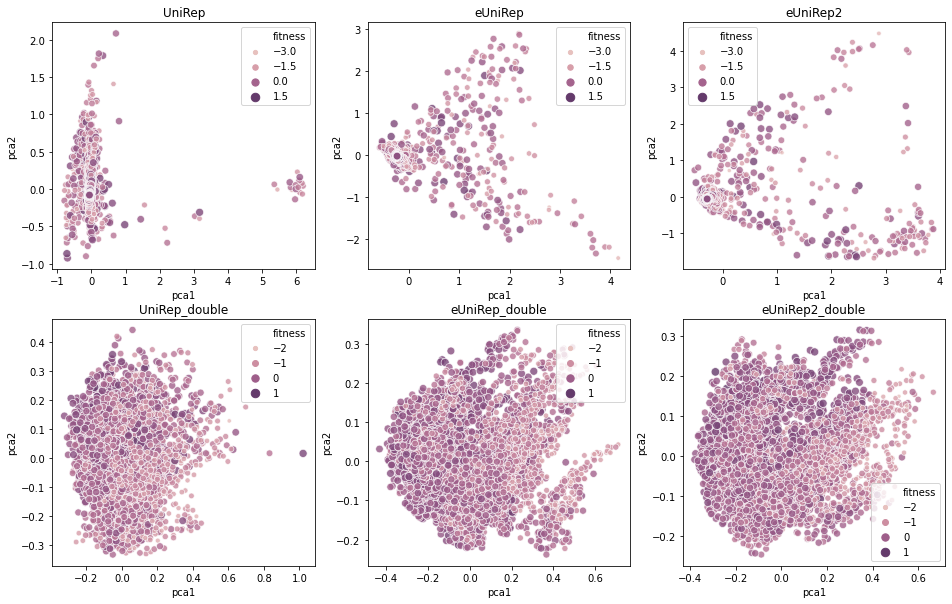

In [15]:
# plot PCA1 vs PCA2 for UniRep and eUniRep
plt.clf()
fig = plt.figure(figsize=(16,10))

x_axis="pca1"
y_axis="pca2"

ax1 = fig.add_subplot(2,3,1, title="UniRep")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_df,
    legend="brief",
    ax=ax1,
    alpha=0.8 #this controls opacity
)

ax2 = fig.add_subplot(2,3,2, title="eUniRep")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_df,
    legend="brief",
    ax=ax2,
    alpha=0.8 #this controls opacity
)

ax3 = fig.add_subplot(2,3,3, title="eUniRep2")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep2_df,
    legend="brief",
    ax=ax3,
    alpha=0.8 #this controls opacity
)

ax4 = fig.add_subplot(2,3,4, title="UniRep_double")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_double_df,
    legend="brief",
    ax=ax4,
    alpha=0.8 #this controls opacity
)

ax5 = fig.add_subplot(2,3,5, title="eUniRep_double")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_double_df,
    legend="brief",
    ax=ax5,
    alpha=0.8 #this controls opacity
)

ax6 = fig.add_subplot(2,3,6, title="eUniRep2_double")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep2_double_df,
    legend="brief",
    ax=ax6,
    alpha=0.8 #this controls opacity
)



<Figure size 432x288 with 0 Axes>

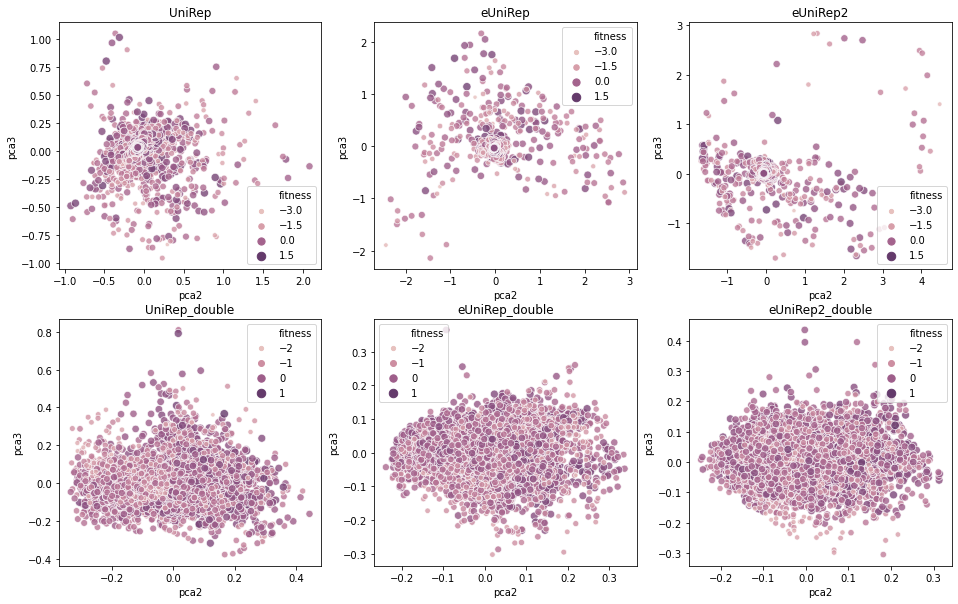

In [16]:
# plot PCA2 vs PCA3 for UniRep and eUniRep
plt.clf()
fig = plt.figure(figsize=(16,10))

x_axis = "pca2"
y_axis = "pca3"

ax1 = fig.add_subplot(2,3,1, title="UniRep")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_df,
    legend="brief",
    ax=ax1,
    alpha=0.8 #this controls opacity
)

ax2 = fig.add_subplot(2,3,2, title="eUniRep")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_df,
    legend="brief",
    ax=ax2,
    alpha=0.8 #this controls opacity
)

ax3 = fig.add_subplot(2,3,3, title="eUniRep2")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep2_df,
    legend="brief",
    ax=ax3,
    alpha=0.8 #this controls opacity
)

ax4 = fig.add_subplot(2,3,4, title="UniRep_double")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_double_df,
    legend="brief",
    ax=ax4,
    alpha=0.8 #this controls opacity
)

ax5 = fig.add_subplot(2,3,5, title="eUniRep_double")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_double_df,
    legend="brief",
    ax=ax5,
    alpha=0.8 #this controls opacity
)

ax6 = fig.add_subplot(2,3,6, title="eUniRep2_double")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep2_double_df,
    legend="brief",
    ax=ax6,
    alpha=0.8 #this controls opacity
)


<Figure size 432x288 with 0 Axes>

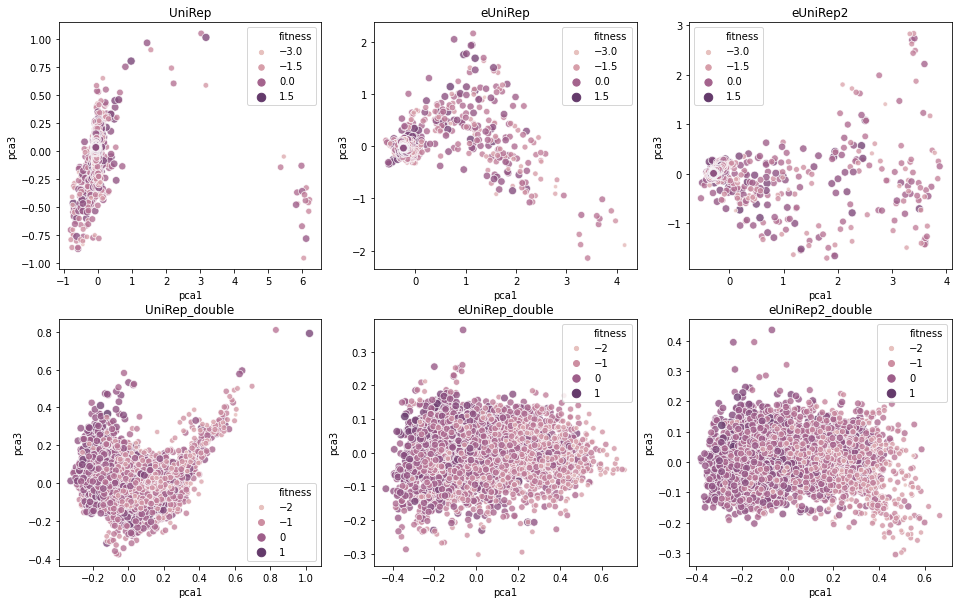

In [17]:
# plot PCA1 vs PCA3 for UniRep and eUniRep
plt.clf()
fig = plt.figure(figsize=(16,10))

x_axis = "pca1"
y_axis = "pca3"

ax1 = fig.add_subplot(2,3,1, title="UniRep")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_df,
    legend="brief",
    ax=ax1,
    alpha=0.8 #this controls opacity
)

ax2 = fig.add_subplot(2,3,2, title="eUniRep")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_df,
    legend="brief",
    ax=ax2,
    alpha=0.8 #this controls opacity
)

ax3 = fig.add_subplot(2,3,3, title="eUniRep2")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep2_df,
    legend="brief",
    ax=ax3,
    alpha=0.8 #this controls opacity
)

ax4 = fig.add_subplot(2,3,4, title="UniRep_double")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_double_df,
    legend="brief",
    ax=ax4,
    alpha=0.8 #this controls opacity
)

ax5 = fig.add_subplot(2,3,5, title="eUniRep_double")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_double_df,
    legend="brief",
    ax=ax5,
    alpha=0.8 #this controls opacity
)

ax6 = fig.add_subplot(2,3,6, title="eUniRep2_double")
sns.scatterplot(
    x=x_axis, y=y_axis,
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep2_double_df,
    legend="brief",
    ax=ax6,
    alpha=0.8 #this controls opacity
)

In [25]:
# How many PCA's do we need to keep to get >90% variance kept?
N_COMPS=5

# UNIREP:
pca_N = PCA(n_components=N_COMPS)
pca_result_N = pca_N.fit_transform(unirep_df[feat_cols].values)
print('UniRep: Explained variation per principal component: {}'.format(np.sum(pca_N.explained_variance_ratio_)))

# eUNIREP:
epca_N = PCA(n_components=N_COMPS)
epca_result_N = epca_N.fit_transform(eunirep_df[feat_cols].values)
print('eUniRep: Explained variation per principal component: {}'.format(np.sum(epca_N.explained_variance_ratio_)))

# eUNIREP2:
epca2_N = PCA(n_components=N_COMPS)
epca2_result_N = epca2_N.fit_transform(eunirep2_df[feat_cols].values)
print('eUniRep2: Explained variation per principal component: {}'.format(np.sum(epca2_N.explained_variance_ratio_)))

# UNIREP_double:
pca_double_N = PCA(n_components=N_COMPS)
pca_double_result_N = pca_double_N.fit_transform(unirep_double_df[feat_cols].values)
print('UniRep_double: Explained variation per principal component: {}'.format(np.sum(pca_double_N.explained_variance_ratio_)))

# eUNIREP_double:
epca_double_N = PCA(n_components=N_COMPS)
epca_double_result_N = epca_double_N.fit_transform(eunirep_double_df[feat_cols].values)
print('eUniRep_double: Explained variation per principal component: {}'.format(np.sum(epca_double_N.explained_variance_ratio_)))

# eUNIREP2_double:
epca2_double_N = PCA(n_components=N_COMPS)
epca2_double_result_N = epca2_double_N.fit_transform(eunirep2_double_df[feat_cols].values)
print('eUniRep2_double: Explained variation per principal component: {}'.format(np.sum(epca2_double_N.explained_variance_ratio_)))


UniRep: Explained variation per principal component: 0.8155037760734558
eUniRep: Explained variation per principal component: 0.7205701470375061
eUniRep2: Explained variation per principal component: 0.7901199460029602
UniRep_double: Explained variation per principal component: 0.5880990028381348
eUniRep_double: Explained variation per principal component: 0.7369013428688049
eUniRep2_double: Explained variation per principal component: 0.7173797488212585


In [26]:
# run TSNE with 2 components on the 20-component PCAs

# UNIREP:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result_N)

# add tsne results to dataframe
unirep_df['tsne-2d-1'] = tsne_results[:,0]
unirep_df['tsne-2d-2'] = tsne_results[:,1]

# EUNIREP:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(epca_result_N)

# add tsne results to dataframe
eunirep_df['tsne-2d-1'] = tsne_results[:,0]
eunirep_df['tsne-2d-2'] = tsne_results[:,1]

# EUNIREP2:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(epca2_result_N)

# add tsne results to dataframe
eunirep2_df['tsne-2d-1'] = tsne_results[:,0]
eunirep2_df['tsne-2d-2'] = tsne_results[:,1]

# UNIREP_double:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_double_result_N)

# add tsne results to dataframe
unirep_double_df['tsne-2d-1'] = tsne_results[:,0]
unirep_double_df['tsne-2d-2'] = tsne_results[:,1]

# EUNIREP_double:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(epca_double_result_N)

# add tsne results to dataframe
eunirep_double_df['tsne-2d-1'] = tsne_results[:,0]
eunirep_double_df['tsne-2d-2'] = tsne_results[:,1]

# EUNIREP2_double:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(epca2_double_result_N)

# add tsne results to dataframe
eunirep2_double_df['tsne-2d-1'] = tsne_results[:,0]
eunirep2_double_df['tsne-2d-2'] = tsne_results[:,1]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1861 samples in 0.001s...
[t-SNE] Computed neighbors for 1861 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1861
[t-SNE] Computed conditional probabilities for sample 1861 / 1861
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.189331
[t-SNE] KL divergence after 300 iterations: 1.020729
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1861 samples in 0.001s...
[t-SNE] Computed neighbors for 1861 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1861
[t-SNE] Computed conditional probabilities for sample 1861 / 1861
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.760300
[t-SNE] KL divergence after 300 iterations: 1.102875
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1861 samples in 0.001s...
[t-SNE] Computed neighbors for 1861 samples in 

<Figure size 432x288 with 0 Axes>

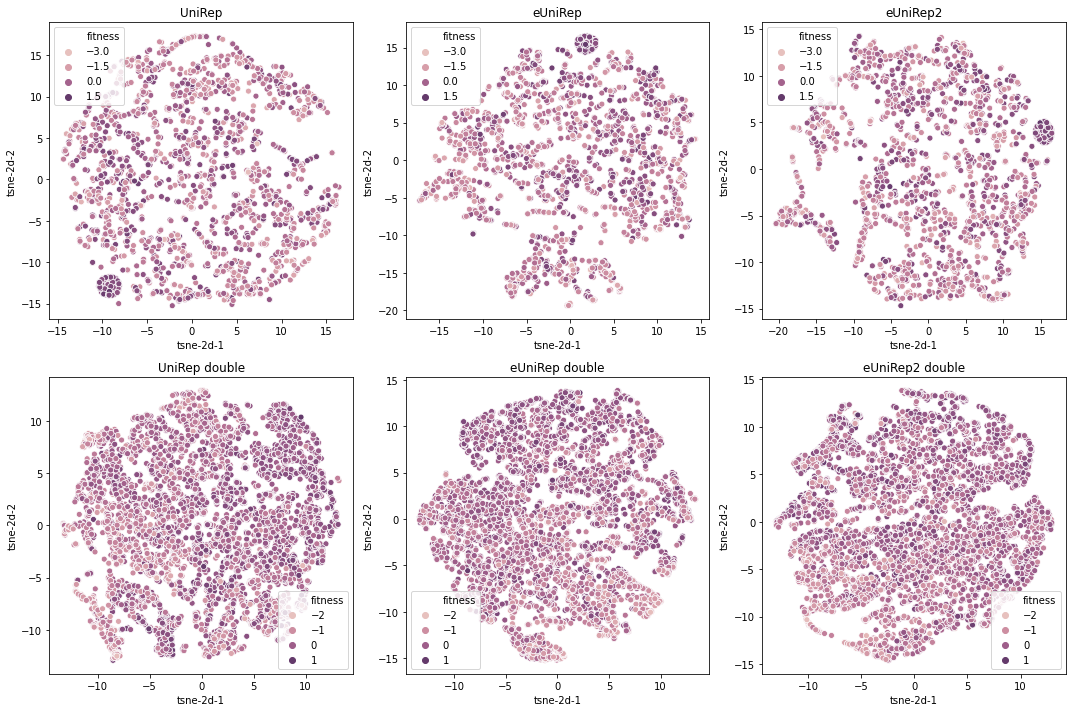

In [27]:
# plot t-SNE's:
plt.clf()
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(2,3,1, title="UniRep")

sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_df,
    legend="brief",
    ax=ax1,
    #alpha=0.3
)

ax2 = fig.add_subplot(2,3,2, title="eUniRep")

sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_df,
    legend="brief",
    ax=ax2,
    #alpha=0.3
)

ax3 = fig.add_subplot(2,3,3, title="eUniRep2")

sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep2_df,
    legend="brief",
    ax=ax3,
    #alpha=0.3
)

ax4 = fig.add_subplot(2,3,4, title="UniRep double")

sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_double_df,
    legend="brief",
    ax=ax4,
    #alpha=0.3
)

ax5 = fig.add_subplot(2,3,5, title="eUniRep double")

sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_double_df,
    legend="brief",
    ax=ax5,
    #alpha=0.3
)

ax6 = fig.add_subplot(2,3,6, title="eUniRep2 double")

sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep2_double_df,
    legend="brief",
    ax=ax6,
    #alpha=0.3
)


plt.tight_layout()
plt.show()

## Top Model Training & Performance Testing

based on previous trials and how the PCA's look we only focus on double_muts for top model training (single muts were pretty terrible)

In [0]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV

In [31]:
# turn ePCA_5 into a dataframe for use as X for top model training

pca_eX_df = pd.DataFrame(epca_double_result_N, columns = [ 'pca' + str(j) for j in range(1, epca_double_result_N.shape[1] + 1) ])
pca_eX_df.head()


,pca1,pca2,pca3,pca4,pca5
0,-0.062722,-0.093144,0.364408,0.342188,1.045738
1,-0.186482,0.003343,-0.003645,-0.102633,0.013702
2,-0.179936,0.017798,-0.002809,-0.096077,0.004354
3,-0.129274,0.086986,-0.056617,-0.082252,-0.005860
4,-0.170759,0.012683,-0.118007,-0.165083,0.081635


UniRep alpha chosen: 0.05736152510448681
eUniRep alpha chosen: 0.05736152510448681
eUniRep2 alpha chosen: 0.05736152510448681
PCA_eUniRep alpha chosen: 0.1082636733874054


<Figure size 432x288 with 0 Axes>

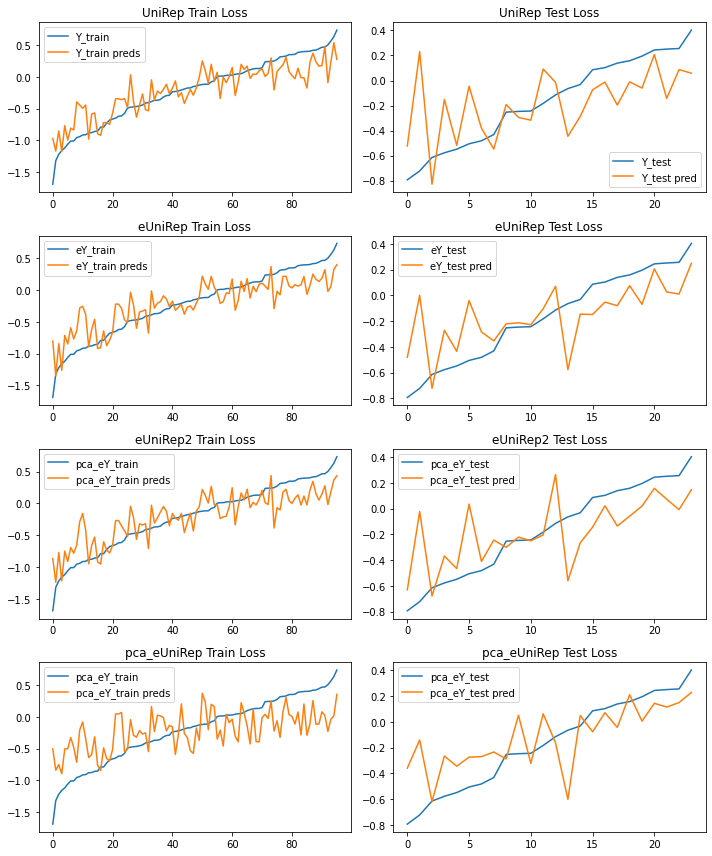

In [34]:
# randomly select subset of sequence as input data
np.random.seed(42)
rndperm = np.random.permutation(unirep_double_df.shape[0])

# number of sequences per batch
BATCH_SIZE = 120

X = unirep_double_df.loc[rndperm[0:BATCH_SIZE], feat_cols]
eX = eunirep_double_df.loc[rndperm[0:BATCH_SIZE], feat_cols]
eX2 = eunirep2_double_df.loc[rndperm[0:BATCH_SIZE], feat_cols]
pca_eX = pca_eX_df.loc[rndperm[0:BATCH_SIZE]]

Y = unirep_double_df.loc[rndperm[0:BATCH_SIZE], "fitness"]

# train-test split for both 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
eX_train, eX_test, eY_train, eY_test = train_test_split(eX, Y, test_size=0.2, random_state=42)
eX2_train, eX2_test, eY2_train, eY2_test = train_test_split(eX2, Y, test_size=0.2, random_state=42)
pca_eX_train, pca_eX_test, pca_eY_train, pca_eY_test = train_test_split(pca_eX, Y, test_size=0.2, random_state=42)

# ridge regression model setup
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

model = RidgeCV(alphas=np.logspace(-4,4,30), cv=kfold)
emodel = RidgeCV(alphas=np.logspace(-4,4,30), cv=kfold)
emodel2 = RidgeCV(alphas=np.logspace(-4,4,30), cv=kfold)
pca_emodel = RidgeCV(alphas=np.logspace(-4,4,30), cv=kfold)

# UNCOMMENT THIS TO SEE ALL THE ALPHAS TESTED
#ridge_params = model.get_params()
#print('alphas to test:', ridge_params['alphas'])

# fit the model
model.fit(X_train, Y_train)
print('UniRep alpha chosen:', str(model.alpha_))
emodel.fit(eX_train, eY_train)
print('eUniRep alpha chosen:', str(emodel.alpha_))
emodel2.fit(eX2_train, eY2_train)
print('eUniRep2 alpha chosen:', str(emodel2.alpha_))
pca_emodel.fit(pca_eX_train, pca_eY_train)
print('PCA_eUniRep alpha chosen:', str(pca_emodel.alpha_))

# predict fitness to get train and test losses
Y_train_preds = model.predict(X_train)
Y_test_preds = model.predict(X_test)
eY_train_preds = emodel.predict(eX_train)
eY_test_preds = emodel.predict(eX_test)
eY2_train_preds = emodel2.predict(eX2_train)
eY2_test_preds = emodel2.predict(eX2_test)
pca_eY_train_preds = pca_emodel.predict(pca_eX_train)
pca_eY_test_preds = pca_emodel.predict(pca_eX_test)

train_loss = np.linalg.norm(Y_train_preds - Y_train)
test_loss = np.linalg.norm(Y_test_preds - Y_test)
etrain_loss = np.linalg.norm(eY_train_preds - eY_train)
etest_loss = np.linalg.norm(eY_test_preds - eY_test)
etrain2_loss = np.linalg.norm(eY2_train_preds - eY2_train)
etest2_loss = np.linalg.norm(eY2_test_preds - eY2_test)
pca_etrain_loss = np.linalg.norm(pca_eY_train_preds - pca_eY_train)
pca_etest_loss = np.linalg.norm(pca_eY_test_preds - pca_eY_test)

# plot train and test losses
plt.clf()
fig = plt.figure(figsize=(10,12))

ax1 = fig.add_subplot(4,2,1, title="UniRep Train Loss")
ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)])
ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)])
ax1.legend(['Y_train','Y_train preds'])

ax2 = fig.add_subplot(4,2,2, title="UniRep Test Loss")
ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)])
ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)])
ax2.legend(['Y_test','Y_test pred'])

ax3 = fig.add_subplot(4,2,3, title="eUniRep Train Loss")
ax3.plot(np.arange(len(eY_train)), np.array(eY_train)[np.argsort(eY_train)])
ax3.plot(np.arange(len(eY_train)), np.array(eY_train_preds)[np.argsort(eY_train)])
ax3.legend(['eY_train','eY_train preds'])

ax4 = fig.add_subplot(4,2,4, title="eUniRep Test Loss")
ax4.plot(np.arange(len(eY_test)), np.array(eY_test)[np.argsort(eY_test)])
ax4.plot(np.arange(len(eY_test)), np.array(eY_test_preds)[np.argsort(eY_test)])
ax4.legend(['eY_test','eY_test pred'])

ax5 = fig.add_subplot(4,2,5, title="eUniRep2 Train Loss")
ax5.plot(np.arange(len(eY2_train)), np.array(eY2_train)[np.argsort(eY2_train)])
ax5.plot(np.arange(len(eY2_train)), np.array(eY2_train_preds)[np.argsort(eY2_train)])
ax5.legend(['pca_eY_train','pca_eY_train preds'])

ax6 = fig.add_subplot(4,2,6, title="eUniRep2 Test Loss")
ax6.plot(np.arange(len(eY2_test)), np.array(eY2_test)[np.argsort(eY2_test)])
ax6.plot(np.arange(len(eY2_test)), np.array(eY2_test_preds)[np.argsort(eY2_test)])
ax6.legend(['pca_eY_test','pca_eY_test pred'])

ax7 = fig.add_subplot(4,2,7, title="pca_eUniRep Train Loss")
ax7.plot(np.arange(len(pca_eY_train)), np.array(pca_eY_train)[np.argsort(pca_eY_train)])
ax7.plot(np.arange(len(pca_eY_train)), np.array(pca_eY_train_preds)[np.argsort(pca_eY_train)])
ax7.legend(['pca_eY_train','pca_eY_train preds'])

ax8 = fig.add_subplot(4,2,8, title="pca_eUniRep Test Loss")
ax8.plot(np.arange(len(pca_eY_test)), np.array(pca_eY_test)[np.argsort(pca_eY_test)])
ax8.plot(np.arange(len(pca_eY_test)), np.array(pca_eY_test_preds)[np.argsort(pca_eY_test)])
ax8.legend(['pca_eY_test','pca_eY_test pred'])

plt.tight_layout()
plt.show()


## Improvement over random sampling 
Test top model function in the same way as done in Supplementary Figure 2 of the Low-N engineering paper (but for 2MS2 instead of avGFP; and instead of training on Sarkisyan and testing on SynNeigh and FP Homologs, this trains and tests on random splits of the same dataset)

The purpose of doing this despite the clearly good fit function for Ridge Regression (see above) is for use as a comparision for datasets that may look less ideal (i.e. <96 training data points)

In [47]:
# number of batches to test
N_BATCH = 5

# number of sequences per training batch
TRAIN_BATCH_SIZE = 96

# number of sequences per training batch
HOLDOUT_BATCH_SIZE = 960

# number of random trials to perform for baseline
N_RAND_BATCHES = 10

# wild-type fitness
WT_FIT = 0

unirep_scores = []
eunirep_scores = []
eunirep2_scores = []
pca_eunirep_scores = []

for i in range(N_BATCH):
  # change random seed for each batch
  np.random.seed(42*(i+2))
  rndperm = np.random.permutation(unirep_double_df.shape[0])

  # data setup
  X = unirep_double_df.loc[rndperm[0:TRAIN_BATCH_SIZE], feat_cols]
  eX = eunirep_double_df.loc[rndperm[0:TRAIN_BATCH_SIZE], feat_cols]
  eX2 = eunirep2_double_df.loc[rndperm[0:TRAIN_BATCH_SIZE], feat_cols]
  pca_eX = pca_eX_df.loc[rndperm[0:TRAIN_BATCH_SIZE]]
  Y = unirep_double_df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

  X_holdout = unirep_double_df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], feat_cols]
  eX_holdout = eunirep_double_df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], feat_cols]
  eX2_holdout = eunirep2_double_df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], feat_cols]
  pca_eX_holdout = pca_eX_df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE]]
  Y_holdout = unirep_double_df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

  # ridge regression model setup
  kfold = KFold(n_splits=10, shuffle=True)

  model = RidgeCV(alphas=np.logspace(-4,4,20), cv=kfold)
  emodel = RidgeCV(alphas=np.logspace(-4,4,20), cv=kfold)
  emodel2 = RidgeCV(alphas=np.logspace(-4,4,20), cv=kfold)
  pca_emodel = RidgeCV(alphas=np.logspace(-4,4,20), cv=kfold)

  # fit the model
  model.fit(X, Y)
  emodel.fit(eX, Y)
  emodel2.fit(eX2, Y)
  pca_emodel.fit(pca_eX, Y)

  # use model to sort holdout set and get top TRAIN_BATCH_SIZE predicted fitness
  Y_preds = model.predict(X_holdout)
  eY_preds = emodel.predict(eX_holdout)
  eY2_preds = emodel2.predict(eX2_holdout)
  pca_eY_preds = pca_emodel.predict(pca_eX_holdout)

  usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]
  esorted = np.array(Y_holdout)[np.argsort(eY_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]
  esorted2 = np.array(Y_holdout)[np.argsort(eY2_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]
  pca_esorted = np.array(Y_holdout)[np.argsort(pca_eY_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]

  # Note: wild-type fitness = WT_FIT (thats the scoring metric)
  usorted_count = np.sum([1 if i > WT_FIT else 0 for i in usorted])
  esorted_count = np.sum([1 if i > WT_FIT else 0 for i in esorted])
  esorted2_count = np.sum([1 if i > WT_FIT else 0 for i in esorted2])
  pca_esorted_count = np.sum([1 if i > WT_FIT else 0 for i in pca_esorted])

  # randomly shuffle holdout set RAND_BATCHES time
  # and take average of top TRAIN_BATCH_SIZE fitness
  avg_rand_count = 0
  for j in range(N_RAND_BATCHES):
    np.random.seed(42*(i+2) + (1+j))
    rand_Y = np.random.permutation(np.array(Y_holdout))[:int(HOLDOUT_BATCH_SIZE/10)]
    avg_rand_count += np.sum([1 if i > WT_FIT else 0 for i in rand_Y])
  avg_rand_count /= N_RAND_BATCHES

  # final score ratio:
  unirep_scores.append(usorted_count/avg_rand_count)
  eunirep_scores.append(esorted_count/avg_rand_count)
  eunirep2_scores.append(esorted2_count/avg_rand_count)
  pca_eunirep_scores.append(pca_esorted_count/avg_rand_count)

# note: random baseline = 1 (as these are ratios)
print("UniRep:", unirep_scores, "Mean Score:", np.mean(unirep_scores))
print("eUniRep:", eunirep_scores, "Mean Score:", np.mean(eunirep_scores))
print("eUniRep2:", eunirep2_scores, "Mean Score:", np.mean(eunirep2_scores))
print("PCA_eUniRep:", pca_eunirep_scores, "Mean Score:", np.mean(pca_eunirep_scores))


UniRep: [1.6452442159383034, 1.7079207920792079, 1.6708860759493671, 1.9036697247706422, 1.778975741239892] Mean Score: 1.7413393099954824
eUniRep: [1.7480719794344473, 1.8564356435643565, 1.7215189873417722, 1.926605504587156, 2.0754716981132075] Mean Score: 1.865620762608188
eUniRep2: [1.6709511568123394, 1.8316831683168318, 2.1265822784810124, 1.811926605504587, 2.0754716981132075] Mean Score: 1.9033229814455956
PCA_eUniRep: [1.5938303341902313, 1.6336633663366338, 1.2151898734177216, 1.3073394495412844, 1.320754716981132] Mean Score: 1.4141555480934007
